<h1 align=center><font size = 5>The Battle of Neighborhoods</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  [Introduction](#section1)

2.  [Reading, exploring and cleaning the data](#section2)

3.  [EDA](#section3)
    
4.  [Analyze Each Neighborhood](#section4)

5.  [Cluster Neighborhoods](#section5)

6.  [Examine Clusters](#section6)
    </font>
    </div>


In [1]:
# !pip install folium

In [2]:
# !pip install geopandas

In [3]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import itertools

import numpy as np # library to handle data in a vectorized manner

import warnings
warnings.filterwarnings('ignore')

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import plotly.express as px # library for visual analysis
import seaborn as sns # library for visual analysis

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# import geopandas
# import geopy.geocoders

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#for better analysis
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print('Libraries imported.')

Libraries imported.


## 1. Introduction <a class='anchor' id ="section1"><a>



#### Problem Statement and background for the project


In this dataset I will explore two cities of India - Mumbai and Banglore. Suppose a person gets a job in Mumbai and/or in Banglore and they need to find a new place to live along with all the places to explore like trending resturants, food joints, parks, movie theater etc. Based on this assignment they can find a suitable place to live in the city with most favorable options.

The datasets used for this case study is taken from Kaggle (Link provided below for both datasets). Both the dataset includes neighbourhoods, type of properties, price of that properties, total area of the properties with their latitude and longitude. This will help us extract venues from the Foursquare api and divide them into different clusters. Here for the clusters, we will use K-means clustering.

- [Mumbai data set - Kaggle](https://www.kaggle.com/jedipro/flats-for-rent-in-mumbai)
- [Banglore data set- Kaggle](https://www.kaggle.com/sangarshanan/bangalore-apartments-dataset)

## 2. Reading, exploring and cleaning the data <a class='anchor' id= 'section2'><a>

__City 1: Mumbai__
    
_**Reading the mumbai dataset**_ 

In [4]:
mumbai = pd.read_csv('prop_data_clean_Mumbai.csv')
print("Dataset imported!")
mumbai.head(2)


Dataset imported!


area  bathroom_num  bedroom_num    city  \
0  350.0           2.0            1  Mumbai   
1  652.0           2.0            1  Mumbai   

                                                desc     dev_name  \
0  2 Bath,Unfurnished,East facing The project has...          NaN   
1  2 Bath,Semi-Furnished,East facing A 1BHK apart...  Veena Group   

   floor_count  floor_num      furnishing        id              id_string  \
0          NaN        NaN     Unfurnished  45349857  domcache_srp_45349857   
1          NaN        NaN  Semi-Furnished  45960973  domcache_srp_45960973   

    latitude    locality  longitude   post_date     poster_name  price  \
0  19.201336  Malad West  72.825882  2020-01-11   Saurabh Patil   9000   
1  19.410704       Vasai  72.833592  2020-01-11  Gorakh  Chavan   8060   

         project                                             title trans  \
0            NaN            1 BHK Apartment for Rent in Malad West  Rent   
1  Veena Dynasty  1 BHK Apartment for Rent in Veena Dynasty, Vasai  Rent   

        type                                                url user_type  
0  Apartment  /propertyDetails/1-BHK-350-Sq-ft-Multistorey-A...     Agent  
1  Apartment  /propertyDetails/1-BHK-652-Sq-ft-Multistorey-A...     Agent

_The mumbai dataset contains tons of information regaring the location and the type of apartments. However, we only require locality which is the neighbourhood, price of the property, area of the property, type whether it is a apartment or Residential House or Multistorey and geo cordinates i.e. latitude and longitude from the dataset._ 

_Let's check the explore the dataset for structure and missing/duplicate values. Also let's change the column names that suits more to the our analysis._

In [5]:
mumbai = mumbai.loc[:,['locality','price','area','type','latitude','longitude']]

In [6]:
new_columns = ['Neighbourhood','Price','Area (sq.ft)','Type','Latitude','Longitude']
mumbai.columns = new_columns

In [7]:
def initial_steps(df):
                            ### structure of the data
    print(color.BOLD+"Structure of the dataset:"+color.END)
    print('-'*100)
    print()
    print("The dataset has {} rows and {} columns.\n\nTotal elements in this dataset are {}".format(df.shape[0],df.shape[1],df.size))
    print()
                        ### missing values check
    print(color.BOLD+"Missing Values Check"+color.END)
    print('-'*100)
    if df.isnull().sum().any() == True:
        print("There are {} missing values in the dataset! Need further checks!".format(df.isnull().sum().sum()))
    else:
        print("There are no missing values in the dataset")
    print()
                            #### Info
    print(color.BOLD+"Info of the dataset"+color.END)
    print('-'*100)
    print(df.info())
    print()
                    ### Duplicate
    print(color.BOLD+"Duplicate Values Check"+color.END)
    print('-'*100)
    dups = df.duplicated()
    print('Number of duplicate rows = %d' % (dups.sum()))
    print()
    if dups.any() == True:
        print('Needs further analysis!')
    else:
        print('There are no duplicate columns in the dataset.')
    return df[dups].head()
    
    
initial_steps(df=mumbai)

Structure of the dataset:
----------------------------------------------------------------------------------------------------

The dataset has 34348 rows and 6 columns.

Total elements in this dataset are 206088

Missing Values Check
----------------------------------------------------------------------------------------------------
There are 984 missing values in the dataset! Need further checks!

Info of the dataset
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34348 entries, 0 to 34347
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighbourhood  34140 non-null  object 
 1   Price          34348 non-null  int64  
 2   Area (sq.ft)   33572 non-null  float64
 3   Type           34348 non-null  object 
 4   Latitude       34348 non-null  float64
 5   Longitude      34348 non-null  float64
dtypes: float64(

Neighbourhood  Price  Area (sq.ft)       Type   Latitude  Longitude
51              NaN   8000         650.0  Apartment   0.000000   0.000000
88   Bhayandar East   9000           NaN  Apartment  19.304779  72.860413
115      Virar West   8000         630.0  Apartment  19.470536  72.808309
124      Virar West   8000         630.0  Apartment  19.470536  72.808309
126      Virar West   8000         630.0  Apartment  19.471822  72.805372

_This dataset contains 2 object data type `Neighbourhood` and `Type`. `Price`, `Area (sq.ft)`, `Latitude` and `Longitude` are numeric type. There are 34348 rows and 6 columns with 206088 total elements. There are missing and duplicate values that needs further analysis. The memory usage by this data set is 1.6+ MB_

In [8]:
mumbai.drop_duplicates(inplace=True)
if mumbai.duplicated().any() == True:
    print('There are {} duplicate values. Please check the code!'.format(mumbai.duplicated().sum()))
else:
    print("Duplicate rows dropped! There are {} duplicate values now.".format(mumbai.duplicated().sum()))
    

Duplicate rows dropped! There are 0 duplicate values now.


_Let's check the missing status again after dropping all the duplicate rows_

In [9]:
def missing_check(df):
    if df.isnull().sum().any() == True:
        print("There are {} missing values in the dataset! Need further checks!".format(df.isnull().sum().sum()))
    else:
        print("There are no missing values in the dataset")
missing_check(df=mumbai)

There are 871 missing values in the dataset! Need further checks!


In [10]:
print(mumbai.isnull().sum())
print('Total =',mumbai.isnull().sum().sum())

Neighbourhood    198
Price              0
Area (sq.ft)     673
Type               0
Latitude           0
Longitude          0
dtype: int64
Total = 871


_There are 673 missing values in Area (sq.ft). Let's see if we can impute the values._

In [11]:
mumbai['Area (sq.ft)'].describe()

count    30092.000000
mean      1173.552738
std        687.172789
min         10.000000
25%        680.000000
50%       1025.000000
75%       1400.000000
max       9500.000000
Name: Area (sq.ft), dtype: float64

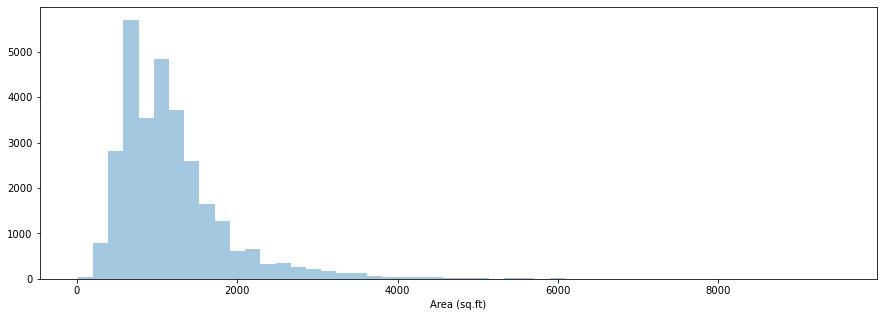

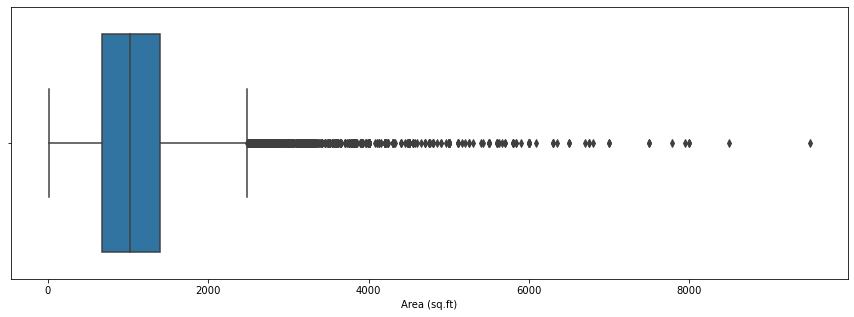

In [12]:
plt.figure(figsize=[15,5])
sns.distplot(mumbai['Area (sq.ft)'],hist=True,kde=False)
plt.show()
plt.figure(figsize=[15,5])
sns.boxplot(mumbai['Area (sq.ft)']);

_Let's impute the values with median_

In [13]:
median = mumbai['Area (sq.ft)'].median()
print("The median for Area (sq.ft) is",median)
mumbai['Area (sq.ft)'].fillna(median,inplace=True)
print("NA replaced with median value.\nMissing values in Area (sq.ft) column:",mumbai['Area (sq.ft)'].isnull().sum())

The median for Area (sq.ft) is 1025.0
NA replaced with median value.
Missing values in Area (sq.ft) column: 0


_There are 198 Neighbourhood without any names, we can drop this rows._

In [14]:
mumbai.replace("",np.nan,inplace=True)
mumbai.dropna(subset=['Neighbourhood'], inplace=True)

In [15]:
print("Missing values in Neighbourhood column:",mumbai['Neighbourhood'].isnull().sum())

Missing values in Neighbourhood column: 0


_Let's also remove the dataset with the Latitude and Longitude with 0 values_

In [16]:
mumbai = mumbai[mumbai['Longitude']!=0]

_Grouping the same city names_

In [17]:
Malad = []
Kandivali = []
Virar = []
Borivali = []
for i in mumbai['Neighbourhood']:
    if i.startswith('Malad') == True or 'Malad' in i:
        Malad.append(i)
    elif i.startswith('Kandivali') == True or 'Kandivali' in i or 'Charkop' in i:
        Kandivali.append(i)
    elif i.startswith('Virar') == True or 'Virar' in i:
        Virar.append(i)
    elif i.startswith('Borivali') == True or 'Borivali' in i:
        Borivali.append(i)
        
print(set(Malad))
print(set(Kandivali))
print(set(Virar))
print(set(Borivali))

{'Malad', 'Shivaji Nagar Malad East', 'Malad West', 'Malad East'}
{'Charkop Sector 6', 'Charkop Sector 8', 'Kandivali West', 'Charkop Sector 2', 'Thakur Village, Kandivali East', 'Charkop', 'Charkop Sector 1', 'Ekta Nagar Charkop', 'Charkop Village', 'Charkop Industrial Estate', 'Charkop Sector 3', 'Kandivali East', 'Charkop Sector 4', 'Kandivali'}
{'Virar East', 'Virar', 'Virar West'}
{'Borivali', 'Borivali East', 'Borivali West'}


In [18]:
mumbai['Neighbourhood'].replace(to_replace=Kandivali,value='Kandivali',inplace=True)
mumbai['Neighbourhood'].replace(to_replace=Malad,value='Malad',inplace=True)
mumbai['Neighbourhood'].replace(to_replace=Virar,value='Virar',inplace=True)
mumbai['Neighbourhood'].replace(to_replace=Borivali,value='Borivali',inplace=True)

In [19]:
mumbai.drop_duplicates(inplace=True)

_Now that we have binned the same neighbourhoods together and cleaned the data let's proceed with outliers check._

_**Outliers check**_

In [20]:
sorted(mumbai)

Q1=mumbai.quantile(0.25)
Q3=mumbai.quantile(0.75)
IQR=Q3-Q1

In [21]:
iqr = ((mumbai < (Q1 - 1.5 * IQR)) |(mumbai > (Q3 + 1.5 * IQR))).any()
iqr = iqr.to_frame().reset_index().rename(columns={'index':'Columns',0:'Outliers'})
outliers = iqr[iqr['Outliers']==True]
outliers

Columns  Outliers
0  Area (sq.ft)      True
1      Latitude      True
2     Longitude      True
4         Price      True

_We will only look for the outliers in Area (sq. ft) and Price_

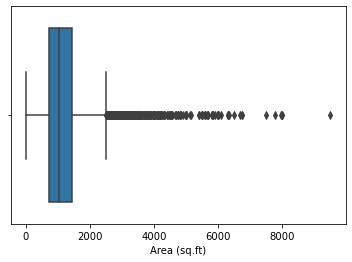

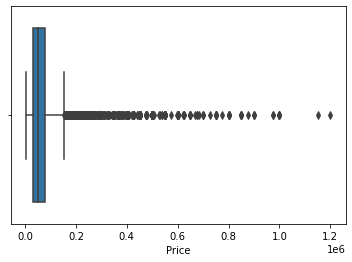

In [22]:
sns.boxplot(mumbai['Area (sq.ft)'])
plt.show()
sns.boxplot(mumbai['Price'])
plt.show()

In [23]:
mumbai = mumbai[mumbai['Area (sq.ft)']>mumbai['Area (sq.ft)'].quantile(0.25)]
mumbai = mumbai[mumbai['Price']<mumbai['Price'].quantile(0.99)]

_We have cleaned all the bad data now. For better analysis let's take sample of 500 entries from our cleaned dataset. Let's check the missing status and dimensions of the data again again._

In [24]:
mumbai = mumbai.sample(n=500)

In [25]:
print("The dataset now has {} rows and {} columns.".format(mumbai.shape[0],mumbai.shape[1]))
missing_check(df=mumbai)

The dataset now has 500 rows and 6 columns.
There are no missing values in the dataset


In [26]:
print("There are {} total neighbourhoods and {} types of properties in Mumbai.".format(len(mumbai["Neighbourhood"].unique()),
                                                                                      len(mumbai["Type"].unique())))

There are 137 total neighbourhoods and 3 types of properties in Mumbai.


_**Let's explore random neighbourhoods in Mumbai before importing venues from Foursquare**_

In [27]:
fig = px.bar(data_frame=mumbai.sample(n=150),x='Neighbourhood',y='Price',color='Type',
             title="Price and type of properties in random neighbourhoods in Mumbai")
fig.show()

In [28]:
fig = px.scatter(data_frame=mumbai,x='Neighbourhood',y='Area (sq.ft)',color='Type',
             title="Price, type and Area (sq.ft) of properties in random neighbourhoods in Mumbai")
fig.show()

__Getting venues from Foursquare__

__Define Foursquare Credentials and Version__


In [29]:
# @hidden_cell.
CLIENT_ID = '4B3ATA5MMVEF3LUH5IXFYZLIYLOGGRJ2SNRMVYVVLLGNDSI0' # your Foursquare ID
CLIENT_SECRET = '54ARDTVWDKTXFW4XBIZTYM54LRHCW5C1B41KJRLRUBSOQAWR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails are imported.')
print("Version:",VERSION)
print("Limit:",LIMIT)

Your credentails are imported.
Version: 20180605
Limit: 100


_Get the neighborhood's name._

In [30]:
# Get the neighborhood's name.
mumbai.iloc[0, 0]

'Lokhandwala Complex'

Get the neighborhood's latitude and longitude values.


In [31]:
neighborhood_latitude = mumbai.iloc[0,-2] # neighborhood latitude value
neighborhood_longitude = mumbai.iloc[0, -1] # neighborhood longitude value

neighborhood_name = mumbai.iloc[0,0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Lokhandwala Complex are 19.1420955657959, 72.826171875.


#### Now, let's get the top 100 venues that are in Malad West within a radius of 500 meters.


In [32]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


Send the GET request and examine the resutls


In [33]:
results = requests.get(url).json()

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                     categories        lat        lng
0      Eden Bakery                         Bakery  19.142848  72.824764
1  Mad Over Donuts                     Donut Shop  19.142644  72.824767
2    Guru Da Dhaba  Vegetarian / Vegan Restaurant  19.141420  72.825171
3       Breadkraft                         Bakery  19.142727  72.824793
4          Sasural              Indian Restaurant  19.140284  72.826088

And how many venues were returned by Foursquare?


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Mumbai


#### Now the code below will run the above function on each neighborhood and create a new dataframe called _mumbai_venues_.


In [38]:
mumbai_venues = getNearbyVenues(names=mumbai['Neighbourhood'],
                                   latitudes=mumbai['Latitude'],
                                   longitudes=mumbai['Longitude']
                                  )


Lokhandwala Complex
Powai
Cuffe Parade
Santacruz East
Film City Road
Kalina
Vidya Nagari
Worli
Chembur
Powai
Vikhroli
Kanjurmarg East
Andheri West
Central Area
Dadar West
CAMA Industrial Estate
Kalina
Andheri West
Andheri West
Malad
Mumbai Central
Goregaon East
Kandivali
Andheri East
Andheri West
Shell Colony
Sarvodaya Nagar
Hatkesh Udyog
Goregaon East
Prabhadevi
LBS Marg
Dadar West
4 Bunglows
Lokhandwala Complex
Worli
Powai lake
Chembur
Virar
Grant Road
Ghatkopar West
Film City
Central Area
Chembur
Worli
Gokuldham
Worli Naka Acharaya Atre Chowk
Prem Nagar
Lokhandwala Complex
Oshiwara
4 Bunglows
Wadala
Sewri
Sakinaka Junction
Amboli
Mahavir Nagar
LBS Marg
Dadar East
Virar
Marol
Bandra West
Andheri West
Malvani
Kandivali
New Link Road
Parel
Vikhroli East
Mira Road
Sewri
Parel
Bhandup West
Mulund West
Sakinaka Junction
Sai Baba Complex
Datta Pada
Worli
Kalina
Vikhroli
Andheri East
Andheri West
Mulund West
Powai
Virar
Bhandup West
Santacruz East
Dadar West
Lokhandwala Twp
Bandra East
Mulu

In [39]:
print('{} venues were returned by Foursquare.'.format(mumbai_venues.shape[0]))

6516 venues were returned by Foursquare.


In [40]:
print(mumbai_venues.shape)
mumbai_venues.head()

(6516, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Lokhandwala Complex              19.142096               72.826172   
1  Lokhandwala Complex              19.142096               72.826172   
2  Lokhandwala Complex              19.142096               72.826172   
3  Lokhandwala Complex              19.142096               72.826172   
4  Lokhandwala Complex              19.142096               72.826172   

             Venue  Venue Latitude  Venue Longitude  \
0      Eden Bakery       19.142848        72.824764   
1  Mad Over Donuts       19.142644        72.824767   
2    Guru Da Dhaba       19.141420        72.825171   
3       Breadkraft       19.142727        72.824793   
4          Sasural       19.140284        72.826088   

                  Venue Category  
0                         Bakery  
1                     Donut Shop  
2  Vegetarian / Vegan Restaurant  
3                         Bakery  
4              Indian Restaurant

In [41]:
latitude = 19.0760
longitude = 72.8777
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.076, 72.8777.


In [42]:
# create map of New York using latitude and longitude values
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, Rates, mumbai_list in zip(mumbai['Latitude'], mumbai['Longitude'], mumbai['Price'],
                                           mumbai['Neighbourhood']):
    label = '{}, {}'.format(mumbai_list, Rates)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

_Our data for Mumbai neighbourhoods is now complete._

__City 2: Bangalore__

_Let's now import that data set for Banglore city_

In [43]:
banglore_apt = pd.read_csv('apartment_data_Banglore.csv')
print("Dataset imported.")

Dataset imported.


In [44]:
banglore_apt.drop('geometry',axis=1,inplace=True)

In [45]:
lst = []
for i in banglore_apt['names']:
    a = str(i).split()
    String = " ".join(a[:-1])
    lst.append(String)


In [46]:
banglore_apt['names'] = np.array(lst)

_Latitudes and Longitude for Banglore neighbourhoods_

In [47]:
banglore_apt.head()

names        lat        lon
0               Purva Skydale  12.894033  77.662362
1   Salarpuria Sattva Cadenza  12.889441  77.640221
2             Shriram Summitt  12.836068  77.667242
3               Shriram Luxor  13.085249  77.654915
4  Ecolife Elements Of Nature  12.938728  77.731126

_Propery details in Banglore neighbourhoods._

In [48]:
banglore_loc = pd.read_csv('blore_apartment_data_Banglore.csv')
banglore_loc.head()


names             Price             Area  \
0  Salarpuria Sattva Cadenza     39 L -41.65 L        755 sq.ft   
1  Salarpuria Sattva Cadenza        55 L -75 L  1175-1275 sq.ft   
2  Salarpuria Sattva Cadenza  70.04 L -73.30 L  1335-1340 sq.ft   
3  Salarpuria Sattva Cadenza        65 L -95 L  1365-1595 sq.ft   
4              Purva Skydale  76.25 L -1.75 Cr  1273-1371 sq.ft   

           Unit Type  
0    1 BHK Apartment  
1    2 BHK Apartment  
2  2.5 BHK Apartment  
3    3 BHK Apartment  
4    2 BHK Apartment

_Let's merge both the dataset._

In [49]:
banglore = banglore_loc.merge(banglore_apt,on='names',how='left')

banglore.columns = new_columns
banglore.head()

Neighbourhood             Price     Area (sq.ft)  \
0  Salarpuria Sattva Cadenza     39 L -41.65 L        755 sq.ft   
1  Salarpuria Sattva Cadenza        55 L -75 L  1175-1275 sq.ft   
2  Salarpuria Sattva Cadenza  70.04 L -73.30 L  1335-1340 sq.ft   
3  Salarpuria Sattva Cadenza        65 L -95 L  1365-1595 sq.ft   
4              Purva Skydale  76.25 L -1.75 Cr  1273-1371 sq.ft   

                Type   Latitude  Longitude  
0    1 BHK Apartment  12.889441  77.640221  
1    2 BHK Apartment  12.889441  77.640221  
2  2.5 BHK Apartment  12.889441  77.640221  
3    3 BHK Apartment  12.889441  77.640221  
4    2 BHK Apartment  12.894033  77.662362

_Now that we got our data for Bangalore let's explore our data._

In [50]:
initial_steps(df=banglore)

Structure of the dataset:
----------------------------------------------------------------------------------------------------

The dataset has 2881 rows and 6 columns.

Total elements in this dataset are 17286

Missing Values Check
----------------------------------------------------------------------------------------------------
There are 895 missing values in the dataset! Need further checks!

Info of the dataset
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 2880
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighbourhood  2881 non-null   object 
 1   Price          2758 non-null   object 
 2   Area (sq.ft)   2711 non-null   object 
 3   Type           2881 non-null   object 
 4   Latitude       2580 non-null   float64
 5   Longitude      2580 non-null   float64
dtypes: float64(2), 

Neighbourhood             Price     Area (sq.ft)  \
184  The Central Regency Address     85 L -1.24 Cr  1454-1609 sq.ft   
186  The Central Regency Address  1.05 Cr -1.64 Cr  1920-2105 sq.ft   
188  The Central Regency Address           1.50 Cr       1920 sq.ft   
203    Premier Inspira Maplewood     60 L -83.97 L  1168-1369 sq.ft   
205    Premier Inspira Maplewood     79 L -1.04 Cr  1402-1633 sq.ft   

                Type   Latitude  Longitude  
184  2 BHK Apartment  12.921034  77.670640  
186  3 BHK Apartment  12.921034  77.670640  
188  4 BHK Apartment  12.921034  77.670640  
203  2 BHK Apartment  12.905424  77.699319  
205  3 BHK Apartment  12.905424  77.699319

_The dataset has 2881 rows and 6 columns. Total elements in this dataset are 17286. There are same columns in this dataset as in Mumbai with price and Area(sq.ft) columns as category. There are missing and duplicate values in the data that needs further analysis. Total memory usage by the data set is 157.6+ KB._

_Let's start by removing all the duplicate values from the dataset._

In [51]:
banglore.drop_duplicates(inplace=True)
if banglore.duplicated().any() == True:
    print('There are {} duplicate values. Please check the code!'.format(banglore.duplicated().sum()))
else:
    print("Duplicate rows dropped! There are {} duplicate values now.".format(banglore.duplicated().sum()))
    

Duplicate rows dropped! There are 0 duplicate values now.


_Let's check the missing status after dropping all the duplicate values_

In [52]:
missing_check(df=banglore)

There are 873 missing values in the dataset! Need further checks!


In [53]:
print(banglore.isnull().sum())
print("Total =",banglore.isnull().sum().sum())

Neighbourhood      0
Price            111
Area (sq.ft)     160
Type               0
Latitude         301
Longitude        301
dtype: int64
Total = 873


_Let's impute the missing values in Price and Area (sq.ft)._

In [54]:
banglore['Price'].describe()

count     2541
unique    2369
top       36 L
freq         6
Name: Price, dtype: object

In [55]:
print("Imputing missing values in Price columns with the mode:",banglore['Price'].mode()[0])
banglore['Price'].fillna(banglore['Price'].mode()[0],inplace=True)
print("Missing values in Price = ",banglore['Price'].isnull().sum())

Imputing missing values in Price columns with the mode: 36 L
Missing values in Price =  0


In [56]:
banglore['Area (sq.ft)'].describe()

count           2492
unique          2132
top       1200 sq.ft
freq              14
Name: Area (sq.ft), dtype: object

In [57]:
print("Imputing missing values in Area (sq.ft) columns with the mode:",banglore['Area (sq.ft)'].mode()[0])
banglore['Area (sq.ft)'].fillna(banglore['Area (sq.ft)'].mode()[0],inplace=True)
print("Missing values in Area (sq.ft) = ",banglore['Area (sq.ft)'].isnull().sum())

Imputing missing values in Area (sq.ft) columns with the mode: 1200 sq.ft
Missing values in Area (sq.ft) =  0


_Now that we have imputed missing values in Price and Area (sq.ft), let's check the missing status again._

In [58]:
missing_check(df=banglore)

There are 602 missing values in the dataset! Need further checks!


In [59]:
banglore.isnull().sum()

Neighbourhood      0
Price              0
Area (sq.ft)       0
Type               0
Latitude         301
Longitude        301
dtype: int64

In [60]:
banglore.replace("",np.nan,inplace=True)
banglore.dropna(subset=['Latitude'], inplace=True)
banglore.dropna(subset=['Longitude'], inplace=True)
print("Missing values actioned!")
missing_check(df=banglore)

Missing values actioned!
There are no missing values in the dataset


_Let's check the Latitude and Longitude for the Banglore locations._

In [61]:
banglore.describe()

Latitude    Longitude
count  2351.000000  2351.000000
mean     12.989273    77.499269
std       0.935852     5.180894
min      12.710155   -99.901813
25%      12.881693    77.600475
50%      12.938440    77.661921
75%      13.032117    77.711635
max      43.969515    77.998270

_The min and max has proper cordinates and none of them are 0. Both the columns are clean now._

_Let's check the Banglore dataset now._

In [62]:
print("The dataset now has {} rows and {} columns.".format(banglore.shape[0],banglore.shape[1]))
missing_check(df=banglore)

print("There are {} total neighbourhoods and {} types of properties in Banglore.".format(len(banglore["Neighbourhood"].unique()),
                                                                                      len(banglore["Type"].unique())))

The dataset now has 2351 rows and 6 columns.
There are no missing values in the dataset
There are 887 total neighbourhoods and 43 types of properties in Banglore.


In [63]:
banglore = banglore.sample(n=500)

_**Let's explore random neighbourhoods in Mumbai before importing venues from Foursquare**_

In [64]:
fig = px.scatter(data_frame=banglore,x='Neighbourhood',y='Price',color='Type',
             title="Price and type of properties in random neighbourhoods in Banglore")
fig.show()

In [65]:
fig = px.scatter(data_frame=banglore.sample(n=150),x='Neighbourhood',y='Area (sq.ft)',color='Type',
             title="Price, type and Area (sq.ft) of properties in random neighbourhoods in Banglore")
fig.show()

__Getting venues from Foursquare__

In [66]:
# @hidden_cell.
CLIENT_ID = 'M55DMGEQJSCGWLL3NJSZMO1TIYEMC1CTEPX1U3WP4JD0DTCL' # your Foursquare ID
CLIENT_SECRET = 'KCOUK5YDLECR35Y5RWGWYN3V5M5YKPCH322A5UGHAUTAFGJ0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails are imported.')
print("Version:",VERSION)
print("Limit:",LIMIT)

Your credentails are imported.
Version: 20180605
Limit: 100


_Get the neighborhood's name._

In [67]:
# Get the neighborhood's name.
banglore.loc[banglore.index[0], 'Neighbourhood']

'Keystone Sarovar'

Get the neighborhood's latitude and longitude values.


In [68]:
neighborhood_latitude = banglore.loc[banglore.index[0],'Latitude'] # neighborhood latitude value
neighborhood_longitude = banglore.loc[banglore.index[0], 'Longitude'] # neighborhood longitude value

neighborhood_name = banglore.loc[banglore.index[0],'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Keystone Sarovar are 12.8670332, 77.57339809999998.


#### Now, let's get the top 100 venues that are in NVT Mystic Garden within a radius of 500 meters.


In [69]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=M55DMGEQJSCGWLL3NJSZMO1TIYEMC1CTEPX1U3WP4JD0DTCL&client_secret=KCOUK5YDLECR35Y5RWGWYN3V5M5YKPCH322A5UGHAUTAFGJ0&v=20180605&ll=12.8670332,77.57339809999998&radius=500&limit=100'

Send the GET request and examine the resutls


In [70]:
results = requests.get(url).json()

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [71]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [72]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [73]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name               categories        lat        lng
0           Magic Masala  North Indian Restaurant  12.867538  77.571018
1  Mega Xpress Hypermart              Supermarket  12.868950  77.575750
2         ABCP Badminton          Badminton Court  12.863512  77.571274

And how many venues were returned by Foursquare?


In [74]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


#### Now the code below will run the above function on each neighborhood and create a new dataframe called _mumbai_venues_.


In [75]:
banglore_venues = getNearbyVenues(names=banglore['Neighbourhood'],
                                   latitudes=banglore['Latitude'],
                                   longitudes=banglore['Longitude']
                                  )


Keystone Sarovar
TG Epitome
Ozone Urbana Avenue
Prestige Royale Gardens
SJR Vogue
VBHC Palmhaven Phase II
Marvel Sequoia
Prestige Royal Garden 3
Mana Candela
Candeur Carlisle
Mahaveer Cygnet
Brigade Lakefront Blue
SGS Silver Oak
DS Max Splendid
Grand Gandharva
Prestige Royal Garden 3
Prestige Misty Waters phase 1
DSMAX SKYSCAPE
Sipani Bliss 2
RS Sanchike
KMB La Palazzo
JK Suchiraa Villas
Asrithas Grand Living
ATZ Estrella
Century Artizan Phase II
Arge Helios
Salarpuria Sattva Greenage Phase II
A Peace Paramount
Rajarajeshwari Vara
Rand Pride Homes
Lone Star Crexcel Tuscany
Upkar Oakland
ELV KingsLand
The Gran Carmen Address
Salarpuria Sattva Anugraha
Prestige Palms
Prestige Royal Garden 2
Prestige Royale Gardens
Trillium Apartment
Godrej Reserve
Prestige Dolce Vita
Adarsh Palm Retreat
RJ Lake Gardenia
Avani Gardens
Brigade Caladium
New India Tanzanite
Hiranandani Evita
Suvastu Oak Leaf
Prabhavathi Divine
Assetz Lifestyle
Niranjan Genesis
Century Ethos
TG Ascent
Sowmya Shailam
Saranya S

Brigade Panorama Phase II
Sobha Clovelly
Sriven Luminous Amaltas
Brigade Altamont
Raynal Gardens
Svamitva Emerald Square
Prestige Lake Ridge
SKS Garden
Orchid Piccadilly
MV Vajra Value Plus
Windsor Troika
Brigade Atmosphere
Countryside Raindance
NCN Swasthi
Supertech Micasa
DSMAX SKYCITY
Smart Homz Blue Bells
Sipani Wattle Grove
RJ Brooke Square
Sipani Bliss 1
Salarpuria Sattva Opus
Artha Emprasa Startup City
Supertech Micasa
DSMAX STARRY
Candeur Carlisle
GR Elysium 3
The Magic Faraway Tree
Lennar Edifice
Shriram Sameeksha
Skylark Ithaca
Brigade Buena Vista Phase II
DSR White Waters Phase II
DSMAX SKYCLASSIC
Asset Aura
Brigade Orchards Luxury Apartments
Arna Meadows
Rohan Vasantha
Vajram Esteva
Splendid Lake Dews
Canary Woods
Pioneer Sun Blossom
Prestige Kenilworth
Bren Northern Lights
Prisha Orchids
Sizzle Gold Coast
Assetz Leaves & Lives
ARS Bhavisha
Narmada Sri Heights
Shriram Luxor
Brigade Buena Vista Phase I
Pashmina Waterfront
SJR WaterMark
Godrej Eternity Life Plus
Hiranandani Q

In [76]:
print('{} venues were returned by Foursquare.'.format(banglore_venues.shape[0]))

2593 venues were returned by Foursquare.


In [77]:
print(banglore_venues.shape)
banglore_venues.head()

(2593, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Keystone Sarovar              12.867033               77.573398   
1     Keystone Sarovar              12.867033               77.573398   
2     Keystone Sarovar              12.867033               77.573398   
3  Ozone Urbana Avenue              12.975727               77.615850   
4  Ozone Urbana Avenue              12.975727               77.615850   

                   Venue  Venue Latitude  Venue Longitude  \
0           Magic Masala       12.867538        77.571018   
1  Mega Xpress Hypermart       12.868950        77.575750   
2         ABCP Badminton       12.863512        77.571274   
3                 Teppan       12.975727        77.616879   
4             The Oberoi       12.973457        77.618289   

            Venue Category  
0  North Indian Restaurant  
1              Supermarket  
2          Badminton Court  
3      Japanese Restaurant  
4                    Hotel

In [78]:
latitude =12.9716
longitude = 77.5946
print('The geograpical coordinate of Banglore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Banglore are 12.9716, 77.5946.


In [79]:
# create map of New York using latitude and longitude values
map_banglore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, Price, banglore_list in zip(banglore['Latitude'], banglore['Longitude'], banglore['Price'],
                                           banglore['Neighbourhood']):
    label = '{}, {}'.format(banglore_list, Price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_banglore)  
    
map_banglore

_Banglore dataset is now complete. Let's proceed with Exploratory Data Analysis._

## 3. EDA <a class='anchor' id ="section3"><a>



#### Description of the data and how it will be used to solve the problem

#### City 1: Mumbai

__Univariate Analysis__


_Let's check which hood has highest number of venues and what venues are most popular in Mumbai:_ 

In [80]:
px.bar(mumbai_venues['Neighborhood'].value_counts().iloc[:20],title='List of top 20 neighborhoods in Mumbai with highest number of venues')

In [81]:
px.bar(mumbai_venues['Venue Category'].value_counts().iloc[:20,],title='List of top 20 venue categories in Mumbai')

__Bivariate Analysis__

_Let's check which neighborhood have most venues in Mumbai:_

In [82]:
venuecheck = pd.crosstab(mumbai_venues['Neighborhood'],mumbai_venues['Venue Category'],margins=True)
venuecheck.sort_values(by='All',axis=0,ascending=False,inplace=True)
venuecheck.sort_values(by='All',axis=1,ascending=False,inplace=True)
venuecheck.drop('All',axis=0,inplace=True)
venuecheck.drop('All',axis=1,inplace=True)
venuecheck = venuecheck.iloc[:20,:20]
venuecheck.head()

Venue Category       Indian Restaurant  Café  Fast Food Restaurant  \
Neighborhood                                                         
Lokhandwala Complex                 65    35                    32   
Andheri West                        60    27                    23   
Worli                               43    28                    10   
Powai                               41    39                     7   
Chembur                             43    15                    24   

Venue Category       Coffee Shop  Chinese Restaurant  Pizza Place  Bakery  \
Neighborhood                                                                
Lokhandwala Complex           28                  33           18      30   
Andheri West                  29                  24           19      18   
Worli                         25                   2            6      16   
Powai                         14                  18            9      14   
Chembur                        4                   4           26      10   

Venue Category       Restaurant  Bar  Ice Cream Shop  Asian Restaurant  Pub  \
Neighborhood                                                                  
Lokhandwala Complex           5   19               4                14   19   
Andheri West                  5   23               6                15   25   
Worli                        26   12               3                32   15   
Powai                        20   12              11                 6    3   
Chembur                       2    4               6                 7    3   

Venue Category       Lounge  Dessert Shop  Hotel  Department Store  Gym  \
Neighborhood                                                              
Lokhandwala Complex       7            18      0                 0    8   
Andheri West             18            12      5                 7    8   
Worli                     7             0      6                 0    0   
Powai                    16            12     15                19    2   
Chembur                   5             9      0                 2    6   

Venue Category       Italian Restaurant  Clothing Store  Gym / Fitness Center  
Neighborhood                                                                   
Lokhandwala Complex                  12               7                    10  
Andheri West                         12               8                     9  
Worli                                18              14                     5  
Powai                                10               0                     0  
Chembur                               0               0                     0

Text(0.5, 1.0, 'Total count of different types of venues in the area (Mumbai)')

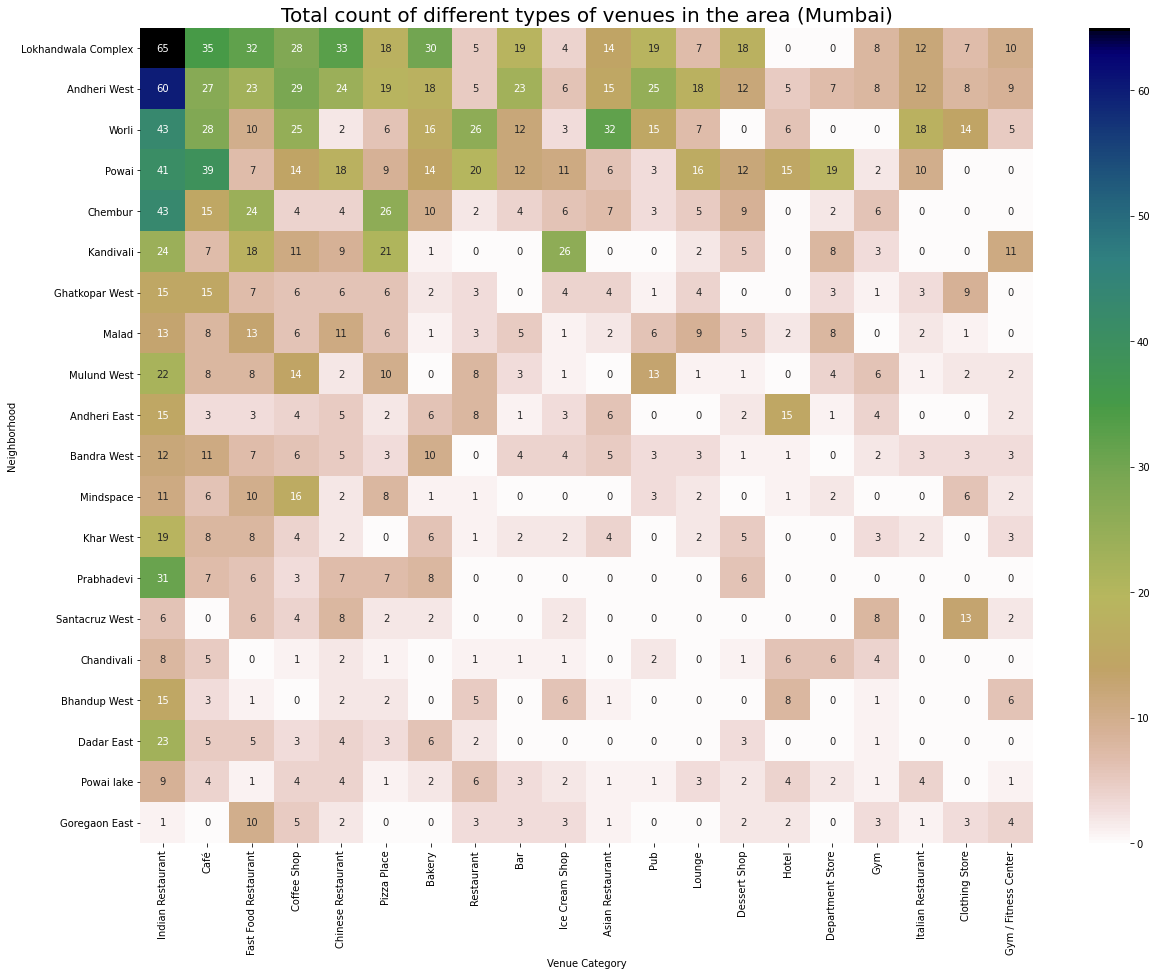

In [83]:
plt.figure(figsize=[20,15])
sns.heatmap(venuecheck,cmap='gist_earth_r',annot=True,fmt='.0f')
plt.title('Total count of different types of venues in the area (Mumbai)',fontsize=20)

#### City 2: Bangalore

__Univariate Analysis__


_Let's check which hood has highest number of venues and what venues are most popular in Banglore:_ 

In [84]:
px.bar(banglore_venues['Neighborhood'].value_counts().iloc[:20],title='List of top 20 neighborhoods in Banglore with highest number of venues')

In [85]:
px.bar(banglore_venues['Venue Category'].value_counts().iloc[:20,],title='List of top 20 venue categories in Banglore')

__Bivariate Analysis__

_Let's check which neighborhood have most venues in Banglore:_

In [86]:
venuecheck = pd.crosstab(banglore_venues['Neighborhood'],banglore_venues['Venue Category'],margins=True)
venuecheck.sort_values(by='All',axis=0,ascending=False,inplace=True)
venuecheck.sort_values(by='All',axis=1,ascending=False,inplace=True)
venuecheck.drop('All',axis=0,inplace=True)
venuecheck.drop('All',axis=1,inplace=True)
venuecheck = venuecheck.iloc[:20,:20]
venuecheck.head()

Venue Category                     Indian Restaurant  Café  Pizza Place  \
Neighborhood                                                              
SKS Garden                                         0     6            2   
Dhanapriya Paradise                                0     6            2   
Citrus Florence                                    0     6            2   
Incor Carmel Heights                               6     9            6   
Puravankara Purva Fountain Square                  3     3            1   

Venue Category                     Hotel  Coffee Shop  Fast Food Restaurant  \
Neighborhood                                                                  
SKS Garden                             4            4                     0   
Dhanapriya Paradise                    4            4                     0   
Citrus Florence                        4            4                     0   
Incor Carmel Heights                   0            0                     6   
Puravankara Purva Fountain Square      6            3                     0   

Venue Category                     Italian Restaurant  Department Store  \
Neighborhood                                                              
SKS Garden                                          8                 0   
Dhanapriya Paradise                                 8                 0   
Citrus Florence                                     8                 0   
Incor Carmel Heights                                3                 0   
Puravankara Purva Fountain Square                   0                 2   

Venue Category                     Bakery  Lounge  Restaurant  Ice Cream Shop  \
Neighborhood                                                                    
SKS Garden                              0       6           2               0   
Dhanapriya Paradise                     0       6           2               0   
Citrus Florence                         0       6           2               0   
Incor Carmel Heights                    0       0           3               0   
Puravankara Purva Fountain Square       2       0           4               1   

Venue Category                     Asian Restaurant  Brewery  Bar  \
Neighborhood                                                        
SKS Garden                                        2        2    2   
Dhanapriya Paradise                               2        2    2   
Citrus Florence                                   2        2    2   
Incor Carmel Heights                              0        6    3   
Puravankara Purva Fountain Square                 2        0    2   

Venue Category                     Chinese Restaurant  Multiplex  \
Neighborhood                                                       
SKS Garden                                          0          0   
Dhanapriya Paradise                                 0          0   
Citrus Florence                                     0          0   
Incor Carmel Heights                                3          9   
Puravankara Purva Fountain Square                   3          0   

Venue Category                     Shopping Mall  Pub  Sandwich Place  
Neighborhood                                                           
SKS Garden                                     2    2               0  
Dhanapriya Paradise                            2    2               0  
Citrus Florence                                2    2               0  
Incor Carmel Heights                           0    0               3  
Puravankara Purva Fountain Square              2    1               0

Text(0.5, 1.0, 'Total count of different types of venues in the area (Banglore)')

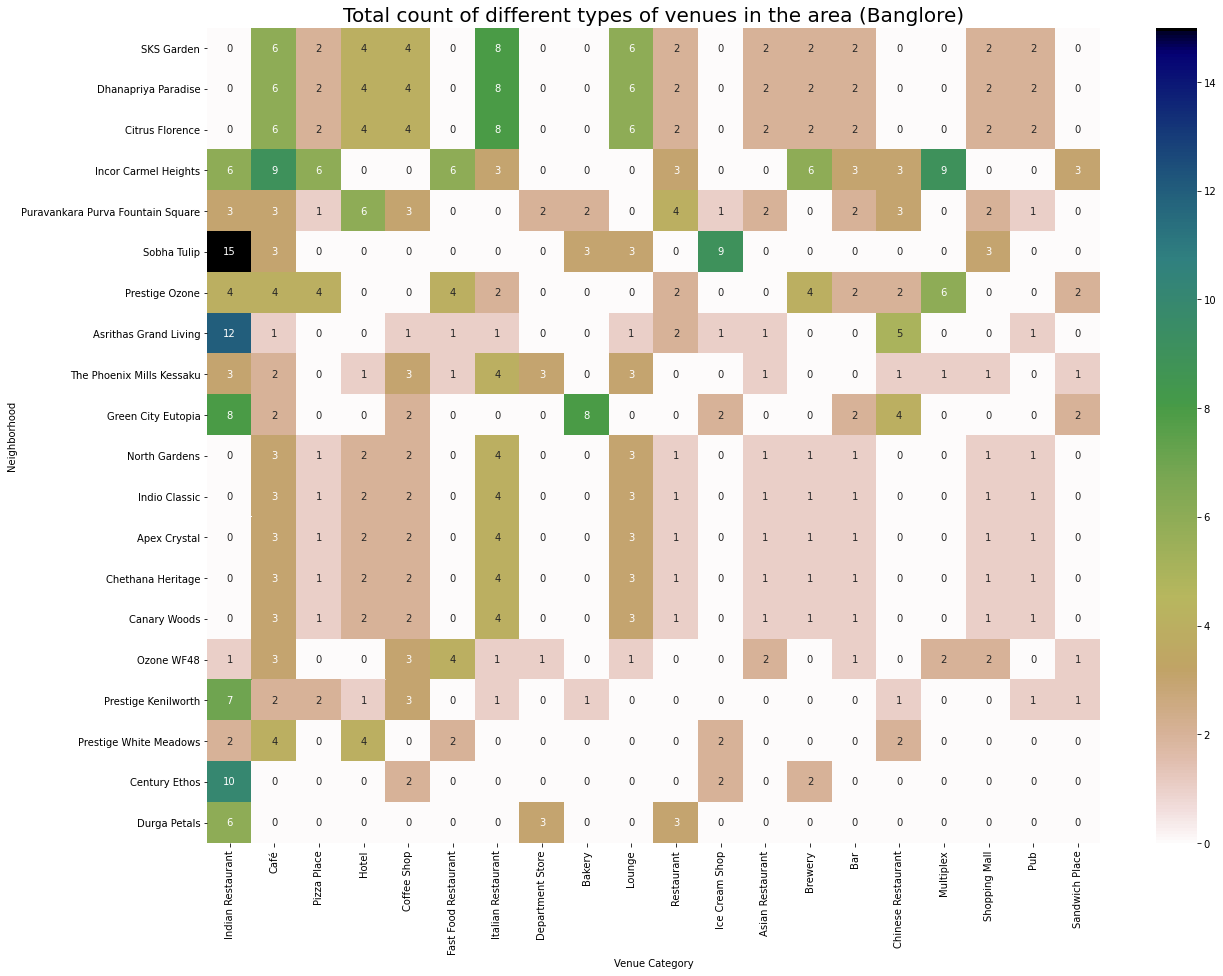

In [87]:
plt.figure(figsize=[20,15])
sns.heatmap(venuecheck,cmap='gist_earth_r',annot=True,fmt='.0f')
plt.title('Total count of different types of venues in the area (Banglore)',fontsize=20)

## 4. Analyze Each Neighborhood <a class='anchor' id ="section4"><a>
    
    
_Let's take the count of all the venues in the neighborhood of Mumbai:_

In [88]:
mumbai_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                
4 Bunglows                                             34   
Acharya A Maharaj Chowk                                50   
Akurli Nagar                                           12   
Altamount Road                                         19   
Amar Nagar                                             11   
Amboli                                                  9   
Andheri East                                          148   
Andheri West                                          558   
Ashok Nagar Western Mumbai                             17   
BEST Housing Colony                                     5   
Bandra Band Stand                                      19   
Bandra East                                            17   
Bandra Kurla Complex                                   53   
Bandra West                                           145   
Best Nagar - Goregaon West                             15   
Bhakti Park                                            31   
Bhandup Industrial Estate                              34   
Bhandup West                                           83   
Bhavani Nagar                                           4   
Bhayandar East                                          4   
Bhoiwada                                                4   
Bimbisar Nagar                                          2   
Borivali                                               30   
Breach Candy                                           23   
Byculla                                                39   
CAMA Industrial Estate                                 16   
Central Area                                           62   
Chakala                                                15   
Chandivali                                            100   
Chembur                                               268   
Chembur Colony                                         29   
Colaba                                                  3   
Cuffe Parade                                           15   
D.N. Nagar                                             13   
Dadar East                                             79   
Dadar West                                             42   
Dahisar East                                           17   
Datta Pada                                             14   
Devi Pada                                               9   
Evershine Nagar                                        12   
Film City                                               2   
Film City Road                                         30   
Four Bungalows                                          4   
Gandhi Nagar                                           20   
Ghatkopar East                                         21   
Ghatkopar West                                        166   
Gokuldham                                              16   
Goregaon East                                          75   
Goregaon West                                          16   
Grant Road                                             12   
Hatkesh Udyog                                          10   
Ishwar Nagar                                            8   
JVLR-Jogeshwari Vikhroli Link Road                      4   
Juhu                                                    8   
Juhu Koliwada                                           9   
Kalina                                                 42   
Kamala City                                            41   
Kanch Pada                                             22   
Kandivali                                             256   
Kanjurmarg East                                         3   
Khar West                                             132   
Kherwadi                                               15   
King Circle                                            34   
Kurla Vidya Vihar Belt                                  4   
Kurla West

In [89]:
print('There are {} uniques categories.'.format(len(mumbai_venues['Venue Category'].unique())))

There are 230 uniques categories.


_Now, let's take the count of all the venues in the neighborhood of Banglore:_

In [90]:
banglore_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                               
A Peace Paramount                                                      1   
ARS Bhavisha                                                           1   
ATZ Estrella                                                           1   
Aashrayaa Eternia                                                      1   
Adarsh Citrine                                                         5   
Adarsh Palm Retreat                                                   24   
Adarsh Palm Retreat Condominiums                                       1   
Adiga 100 trees                                                       21   
Adithya Tranquil                                                       2   
Ajmera Annex                                                          12   
Akme Harmony                                                          17   
Akruthi Spring Woods                                                   4   
Apex Crystal                                                          44   
Aratt Firenza                                                          1   
Arge Helios                                                           12   
Arna Meadows                                                           2   
Arsis Green Hills                                                      8   
Arvind Oasis                                                           6   
Arvind Sporcia                                                         3   
Aryan Golden Arena                                                     2   
Asrithas Grand Living                                                 47   
Assetz East Point                                                      4   
Assetz Soul & Soil                                                     4   
Aster Residential Layout                                              14   
Avani Gardens                                                          4   
Axis Vedam                                                             5   
BRR Sai Sankalp                                                        4   
Bhartiya City 2                                                        1   
Bhartiya City Leela Residences                                         1   
Bhartiya City Nikoo Homes II                                           1   
Blue Bell Homes                                                        5   
Bren Champions Square                                                  4   
Bren Paddington                                                       12   
Brigade Altamont                                                       1   
Brigade Bricklane                                                      3   
Brigade Buena Vista Phase I                                            3   
Brigade Buena Vista Phase II                                           1   
Brigade Caladium                                                       4   
Brigade Cosmopolis - Phase 1 & 2                                      22   
Brigade Lakefront - Amber Block                                       24   
Brigade Lakefront Blue                                                24   
Brigade Meadows                                                        3   
Brigade Orchards Luxury Apartments                                     4   
Brigade Panorama Phase II                                              2   
Brigade Woods                                                          2   
Canary Woods                                                          44   
Candeur Carlisle                                                       6   
Candeur Rise                                                           3   
Century Artizan Phase II                                               2   
Century Ethos                                                         28   
Century Linea                                                          5   
Chaitrashree Royale    

In [91]:
print('There are {} uniques categories.'.format(len(banglore_venues['Venue Category'].unique())))

There are 208 uniques categories.


_Before proceeding to clustering we will perform one-hot encoding to get the venues in the columns._

_for Mumbai:_

In [92]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Neighborhood'] = mumbai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

Zoo  Accessories Store  Advertising Agency  Afghan Restaurant  Airport  \
0    0                  0                   0                  0        0   
1    0                  0                   0                  0        0   
2    0                  0                   0                  0        0   
3    0                  0                   0                  0        0   
4    0                  0                   0                  0        0   

   Airport Food Court  American Restaurant  Arcade  Argentinian Restaurant  \
0                   0                    0       0                       0   
1                   0                    0       0                       0   
2                   0                    0       0                       0   
3                   0                    0       0                       0   
4                   0                    0       0                       0   

   Art Gallery  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0            0                    0                     0                 0   
1            0                    0                     0                 0   
2            0                    0                     0                 0   
3            0                    0                     0                 0   
4            0                    0                     0                 0   

   Athletics & Sports  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0                   0            0              0                0          0   
1                   0            0              0                0          0   
2                   0            0              0                0          0   
3                   0            0              0                0          0   
4                   0            0              0                0          0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Basketball Court  Beach  \
0           0       1     0    0               0                 0      0   
1           0       0     0    0               0                 0      0   
2           0       0     0    0               0                 0      0   
3           0       1     0    0               0                 0      0   
4           0       0     0    0               0                 0      0   

   Bed & Breakfast  Beer Garden  Bengali Restaurant  Big Box Store  \
0                0            0                   0              0   
1                0            0                   0              0   
2                0            0                   0              0   
3                0            0                   0              0   
4                0            0                   0              0   

   Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                         0       0              0          0         0   
1                         0       0              0          0         0   
2                         0       0              0          0         0   
3                         0       0              0          0         0   
4                         0       0              0          0         0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Buffet  \
0              0                     0               0        0       0   
1              0                     0               0        0       0   
2              0                     0               0        0       0   
3              0                     0               0        0       0   
4              0                     0               0        0       0   

   Building  Burger Joint  Burrito Place  Bus Line  Bus Station  Bus Stop  \
0         0             0              0         0            0         0   
1         0             0              0         0            0         0   
2         0             0              0         0            0         0   
3         0    

_for Banglore:_

In [93]:
# one hot encoding
banglore_onehot = pd.get_dummies(banglore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
banglore_onehot['Neighborhood'] = banglore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [banglore_onehot.columns[-1]] + list(banglore_onehot.columns[:-1])
banglore_onehot = banglore_onehot[fixed_columns]

banglore_onehot.head()

Neighborhood  ATM  Afghan Restaurant  Airport  American Restaurant  \
0     Keystone Sarovar    0                  0        0                    0   
1     Keystone Sarovar    0                  0        0                    0   
2     Keystone Sarovar    0                  0        0                    0   
3  Ozone Urbana Avenue    0                  0        0                    0   
4  Ozone Urbana Avenue    0                  0        0                    0   

   Andhra Restaurant  Animal Shelter  Arcade  Arts & Crafts Store  \
0                  0               0       0                    0   
1                  0               0       0                    0   
2                  0               0       0                    0   
3                  0               0       0                    0   
4                  0               0       0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                     0                 0                   0            0   
1                     0                 0                   0            0   
2                     0                 0                   0            0   
3                     0                 0                   0            0   
4                     0                 0                   0            0   

   Automotive Shop  BBQ Joint  Badminton Court  Bakery  Bar  Bed & Breakfast  \
0                0          0                0       0    0                0   
1                0          0                0       0    0                0   
2                0          0                1       0    0                0   
3                0          0                0       0    0                0   
4                0          0                0       0    0                0   

   Beer Garden  Bengali Restaurant  Big Box Store  Bike Shop  Bistro  \
0            0                   0              0          0       0   
1            0                   0              0          0       0   
2            0                   0              0          0       0   
3            0                   0              0          0       0   
4            0                   0              0          0       0   

   Bookstore  Boutique  Bowling Alley  Breakfast Spot  Brewery  \
0          0         0              0               0        0   
1          0         0              0               0        0   
2          0         0              0               0        0   
3          0         0              0               0        0   
4          0         0              0               0        0   

   Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  Bus Line  \
0                0       0         0             0              0         0   
1                0       0         0             0              0         0   
2                0       0         0             0              0         0   
3                0       0         0             0              0         0   
4                0       0         0             0              0         0   

   Bus Station  Bus Stop  Business Service  Cafeteria  Café  Camera Store  \
0            0         0                 0          0     0             0   
1            0         0                 0          0     0             0   
2            0         0                 0          0     0             0   
3            0         0                 0          0     0             0   
4            0         0                 0          0     0             0   

   Cantonese Restaurant  Chaat Place  Chettinad Restaurant  \
0                     0            0                     0   
1                     0            0                     0   
2                     0            0                     0   
3                     0            0                     0   
4                     0            0                     0   

   Chinese Restaurant  

In [359]:
mumbai_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()

In [360]:
banglore_grouped = banglore_onehot.groupby('Neighborhood').mean().reset_index()

In [284]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

_Now, since we want to analyse the most common venues of each neighborhood. Let's merge the dataset with the 10 most common venues in each neighborhood._

_for Mumbai:_

In [285]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_mumbai = pd.DataFrame(columns=columns)
neighborhoods_venues_mumbai['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_mumbai.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_mumbai.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               4 Bunglows                Lounge           Coffee Shop   
1  Acharya A Maharaj Chowk                  Café        Clothing Store   
2             Akurli Nagar            Food Truck                  Bank   
3           Altamount Road                Bakery                  Café   
4               Amar Nagar              Mountain        Ice Cream Shop   

  3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
0     Indian Restaurant    Light Rail Station       Accessories Store   
1     Indian Restaurant           Pizza Place  Furniture / Home Store   
2           Coffee Shop                  Café       Indian Restaurant   
3               Theater    Chinese Restaurant    Fast Food Restaurant   
4     Indian Restaurant                  Park    Fast Food Restaurant   

  6th Most Common Venue                     7th Most Common Venue  \
0          Liquor Store  Residential Building (Apartment / Condo)   
1          Soccer Field                        Chinese Restaurant   
2   Arts & Crafts Store                               Yoga Studio   
3                   Spa                                      Park   
4     Food & Drink Shop                               Coffee Shop   

  8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
0           Pizza Place                Restaurant          Women's Store  
1  Fast Food Restaurant  Mediterranean Restaurant    Sporting Goods Shop  
2           Event Space       Dumpling Restaurant      Electronics Store  
3        Breakfast Spot                   Brewery     Salon / Barbershop  
4    Chinese Restaurant         Electronics Store                Dog Run

_for Banglore:_

In [286]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_banglore = pd.DataFrame(columns=columns)
neighborhoods_venues_banglore['Neighborhood'] = banglore_grouped['Neighborhood']

for ind in np.arange(banglore_grouped.shape[0]):
    neighborhoods_venues_banglore.iloc[ind, 1:] = return_most_common_venues(banglore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_banglore.head()

Neighborhood    1st Most Common Venue 2nd Most Common Venue  \
0  A Peace Paramount  Fruit & Vegetable Store         Women's Store   
1       ARS Bhavisha          Motorcycle Shop         Women's Store   
2       ATZ Estrella      Indie Movie Theater         Women's Store   
3  Aashrayaa Eternia                     Lake         Women's Store   
4     Adarsh Citrine           Breakfast Spot                Lounge   

         3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            French Restaurant            Food Court     Food & Drink Shop   
1               Ice Cream Shop            Food Court     Food & Drink Shop   
2            Electronics Store            Food Court     Food & Drink Shop   
3            French Restaurant            Food Court     Food & Drink Shop   
4  Eastern European Restaurant        Scenic Lookout            Playground   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Food           Flower Shop           Flea Market   
1                  Food           Flower Shop           Flea Market   
2                  Food           Flower Shop           Flea Market   
3                  Food           Flower Shop           Flea Market   
4          Home Service     Food & Drink Shop           Flower Shop   

  9th Most Common Venue      10th Most Common Venue  
0     Fish & Chips Shop  Financial or Legal Service  
1     Fish & Chips Shop  Financial or Legal Service  
2     Fish & Chips Shop  Financial or Legal Service  
3     Fish & Chips Shop  Financial or Legal Service  
4           Flea Market           Fish & Chips Shop

## 5. Cluster Neighborhoods<a class='anchor' id ="section5"><a>

Run _k_-means to cluster the neighborhood into 5 clusters.


In [287]:
# set number of clusters
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 4])

_**Within sum of squares (WSS)**_

_The within-cluster sum of squares is a measure of the variability of the observations within each cluster. In general, a cluster that has a small sum of squares is more compact than a cluster that has a large sum of squares. Clusters that have higher values exhibit greater variability of the observations within the cluster._

In [288]:
wss = [] # Within cluster Sum of squares
for i in range(1,21): # iterating through various number of clusters 1 to 20
    k_means = KMeans(n_clusters = i,random_state=1234) # creating the kmeans model
    k_means.fit(mumbai_grouped_clustering) # fitting the standardized data onto the kmeans model
    wss.append(k_means.inertia_) # Extracting the Within sum of squares or inertia from the model
wss_df = pd.DataFrame(wss,columns = ['WSS']) # putting all the WSS values in a data frame
wss_df['Num_of_clusters'] = range(1,21)
wss_df = wss_df[['Num_of_clusters','WSS']]
wss_df

Num_of_clusters        WSS
0                 1  14.296936
1                 2  13.164581
2                 3  12.594397
3                 4  12.057431
4                 5  11.538266
5                 6  11.226106
6                 7  10.536614
7                 8  10.381287
8                 9   9.879413
9                10   9.748281
10               11   9.144194
11               12   8.880980
12               13   8.542446
13               14   8.310583
14               15   8.145365
15               16   7.943416
16               17   7.706708
17               18   7.447206
18               19   7.329706
19               20   7.033614

_**WSS plot**_

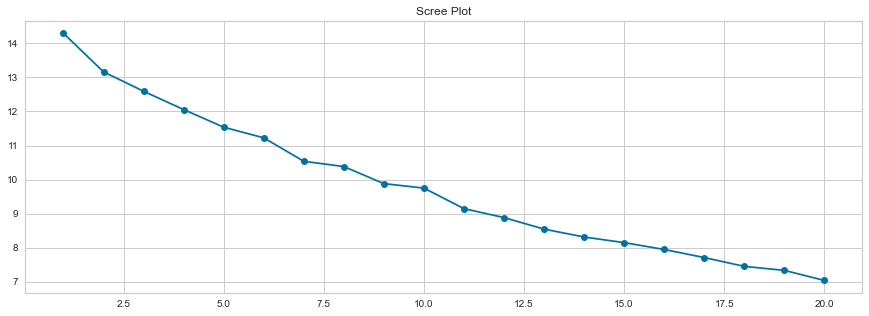

In [289]:
# Plotting the above data in the form of a scree plot
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(wss_df['Num_of_clusters'],wss_df['WSS'],marker='o')
plt.title('Scree Plot')
plt.grid(True);

_**Silhouette Score**_

_Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters._

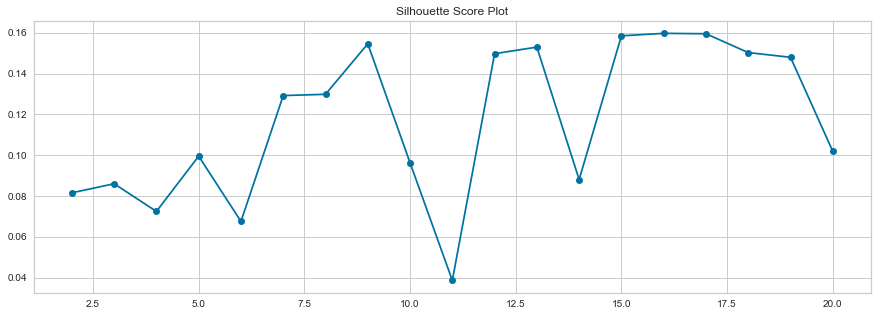

In [290]:
from sklearn.metrics import silhouette_score
sil_score = []
for i in range(2,21):
    k_means = KMeans(n_clusters = i,random_state=1234)
    k_means.fit(mumbai_grouped_clustering)
    clus = k_means.labels_
    sil_score.append(silhouette_score(X=mumbai_grouped_clustering,labels = clus))
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(range(2,21),sil_score,marker='o')
axes.set_title('Silhouette Score Plot')
plt.grid(True);

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

_for Mumbai:_

In [298]:
# add clustering labels
neighborhoods_venues_mumbai.insert(0, 'Cluster Labels', kmeans.labels_)
# neighborhoods_venues_mumbai.set_index('Neighborhood',inplace=True)
mumbai_merged = mumbai

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.merge(neighborhoods_venues_mumbai,left_on='Neighbourhood',right_on='Neighborhood')

mumbai_merged.head() # check the last columns!

Neighbourhood   Price  Area (sq.ft)       Type   Latitude  Longitude  \
0  Lokhandwala Complex   75000        1200.0  Apartment  19.142096  72.826172   
1  Lokhandwala Complex  170000        2798.0  Apartment  19.141714  72.828496   
2  Lokhandwala Complex  130000        2200.0  Apartment  19.146397  72.823466   
3  Lokhandwala Complex  150000        1900.0  Apartment  19.141714  72.828496   
4  Lokhandwala Complex  149000        1850.0  Apartment  19.137100  72.832056   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0     Indian Restaurant                  Café   
1               0     Indian Restaurant                  Café   
2               0     Indian Restaurant                  Café   
3               0     Indian Restaurant                  Café   
4               0     Indian Restaurant                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Chinese Restaurant  Fast Food Restaurant                Bakery   
1    Chinese Restaurant  Fast Food Restaurant                Bakery   
2    Chinese Restaurant  Fast Food Restaurant                Bakery   
3    Chinese Restaurant  Fast Food Restaurant                Bakery   
4    Chinese Restaurant  Fast Food Restaurant                Bakery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Coffee Shop                   Pub                   Bar   
1           Coffee Shop                   Pub                   Bar   
2           Coffee Shop                   Pub                   Bar   
3           Coffee Shop                   Pub                   Bar   
4           Coffee Shop                   Pub                   Bar   

  9th Most Common Venue 10th Most Common Venue  
0           Pizza Place           Dessert Shop  
1           Pizza Place           Dessert Shop  
2           Pizza Place           Dessert Shop  
3           Pizza Place           Dessert Shop  
4           Pizza Place           Dessert Shop

Run _k_-means to cluster the neighborhood into 5 clusters for Banglore data.


In [299]:
# set number of clusters
kclusters = 5

banglore_grouped_clustering = banglore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(banglore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 2])

_within sum of square_

In [300]:
wss = [] # Within cluster Sum of squares
for i in range(1,21): # iterating through various number of clusters 1 to 20
    k_means = KMeans(n_clusters = i,random_state=1234) # creating the kmeans model
    k_means.fit(banglore_grouped_clustering) # fitting the standardized data onto the kmeans model
    wss.append(k_means.inertia_) # Extracting the Within sum of squares or inertia from the model
wss_df = pd.DataFrame(wss,columns = ['WSS']) # putting all the WSS values in a data frame
wss_df['Num_of_clusters'] = range(1,21)
wss_df = wss_df[['Num_of_clusters','WSS']]
wss_df

Num_of_clusters         WSS
0                 1  121.367724
1                 2  113.510109
2                 3  109.582626
3                 4  105.423351
4                 5  103.353801
5                 6  101.182501
6                 7   94.927432
7                 8   94.091955
8                 9   90.462140
9                10   87.731699
10               11   83.878038
11               12   82.248304
12               13   80.068307
13               14   78.112875
14               15   76.010392
15               16   72.845595
16               17   72.951622
17               18   70.525619
18               19   68.288059
19               20   67.620459

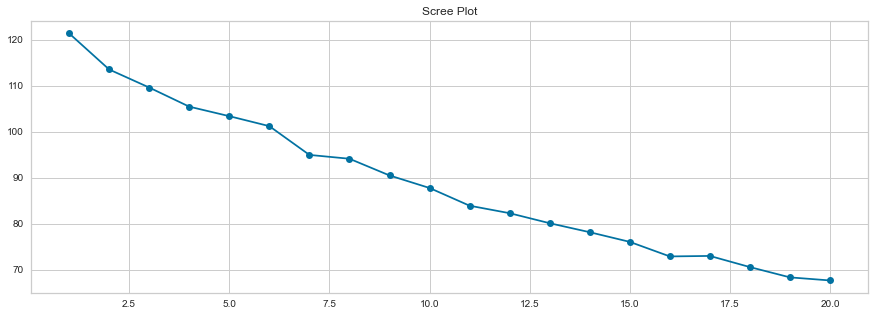

In [301]:
# Plotting the above data in the form of a scree plot
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(wss_df['Num_of_clusters'],wss_df['WSS'],marker='o')
plt.title('Scree Plot')
plt.grid(True);

_Silhouette Score_

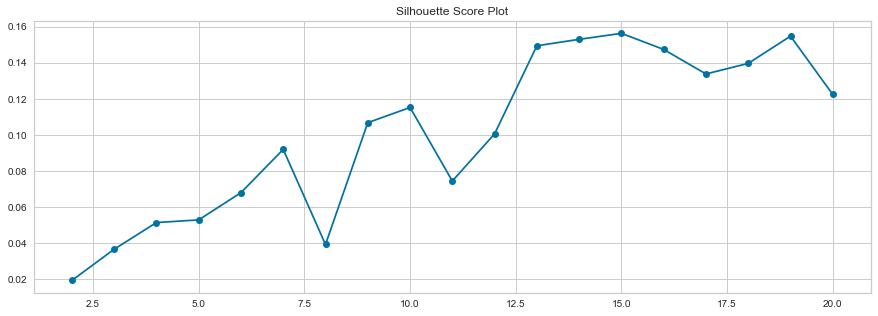

In [302]:
from sklearn.metrics import silhouette_score
sil_score = []
for i in range(2,21):
    k_means = KMeans(n_clusters = i,random_state=1234)
    k_means.fit(banglore_grouped_clustering)
    clus = k_means.labels_
    sil_score.append(silhouette_score(X=banglore_grouped_clustering,labels = clus))
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(range(2,21),sil_score,marker='o')
axes.set_title('Silhouette Score Plot')
plt.grid(True);

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

_for Banglore:_

In [303]:
# add clustering labels
neighborhoods_venues_banglore.insert(0, 'Cluster Labels', kmeans.labels_)
# neighborhoods_venues_mumbai.set_index('Neighborhood',inplace=True)
banglore_merged = banglore

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
banglore_merged = banglore_merged.merge(neighborhoods_venues_banglore,left_on='Neighbourhood',right_on='Neighborhood')

banglore_merged.head() # check the last columns!

Neighbourhood             Price     Area (sq.ft)  \
0         Keystone Sarovar  42.50 L -46.13 L       1200 sq.ft   
1      Ozone Urbana Avenue     58 L -62.50 L  1150-1250 sq.ft   
2  Prestige Royale Gardens           52.90 L       1050 sq.ft   
3  Prestige Royale Gardens     48.76 L -70 L  1285-1300 sq.ft   
4  Prestige Royale Gardens              36 L       1200 sq.ft   

              Type   Latitude  Longitude  Cluster Labels  \
0      2 BHK Villa  12.867033  77.573398               1   
1  2 BHK Apartment  12.975727  77.615850               1   
2  2 BHK PentHouse  13.139508  77.570640               0   
3  3 BHK Apartment  13.139508  77.570640               0   
4      2 BHK Villa  13.139508  77.570640               0   

              Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0         Keystone Sarovar           Supermarket  North Indian Restaurant   
1      Ozone Urbana Avenue                 Hotel                     Café   
2  Prestige Royale Gardens     Indian Restaurant     Karnataka Restaurant   
3  Prestige Royale Gardens     Indian Restaurant     Karnataka Restaurant   
4  Prestige Royale Gardens     Indian Restaurant     Karnataka Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0       Badminton Court         Women's Store         Event Service   
1     Indian Restaurant           Coffee Shop   Japanese Restaurant   
2         Women's Store         Event Service            Food Truck   
3         Women's Store         Event Service            Food Truck   
4         Women's Store         Event Service            Food Truck   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Food Court     Food & Drink Shop                  Food   
1     French Restaurant            Restaurant            Steakhouse   
2            Food Court     Food & Drink Shop                  Food   
3            Food Court     Food & Drink Shop                  Food   
4            Food Court     Food & Drink Shop                  Food   

  9th Most Common Venue 10th Most Common Venue  
0           Flower Shop            Flea Market  
1    Chinese Restaurant                    Bar  
2           Flower Shop            Flea Market  
3           Flower Shop            Flea Market  
4           Flower Shop            Flea Market

## 6. Examine Clusters<a class='anchor' id ="section6"><a>

_Let's create a chart to visualize how the clusters are distributed_

_for Mumbai:_

In [339]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles for our chart is ', total_num_tiles)

Total number of tiles for our chart is  400


_Value counts for each clusters_

In [340]:
waffle = mumbai_merged['Cluster Labels'].value_counts().to_frame()
waffle.reset_index(inplace=True)
waffle.rename(columns={waffle.columns[0]:'Clusters',waffle.columns[1]:'Cluster Labels'},inplace=True)
waffle

Clusters  Cluster Labels
0         0             406
1         2              46
2         4              39
3         3               4
4         1               2

_Computing the proportion of each cluster to fit into the waffle chart._

In [341]:
# compute the proportion of each category with respect to the total
total_values = sum(waffle['Cluster Labels'])
category_proportions = [(float(value) / total_values) for value in waffle['Cluster Labels']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print(waffle.Clusters.values[i],':',proportion)

0 : 0.8169014084507042
2 : 0.0925553319919517
4 : 0.07847082494969819
3 : 0.008048289738430584
1 : 0.004024144869215292


_Computing the number of tiles for each catagory._

In [342]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (waffle.Clusters.values[i], ': ' , tiles)

0 :  327
2 :  37
4 :  31
3 :  3
1 :  2


_Populating the waffle chart_

In [343]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


<Figure size 576x396 with 0 Axes>

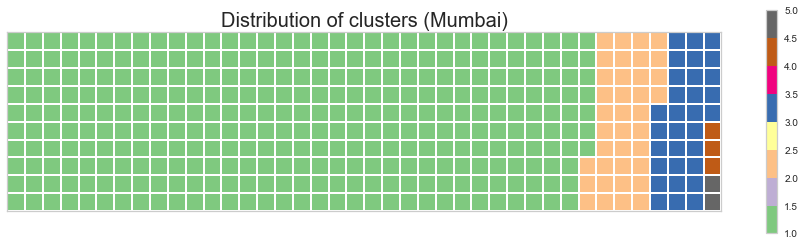

Cluster 1 has 406 records
Cluster 2 has 46 records
Cluster 3 has 39 records
Cluster 4 has 4 records
Cluster 5 has 2 records


In [344]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.Accent
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.title("Distribution of clusters (Mumbai)",fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()
print("Cluster 1 has {} records".format(waffle.iloc[0,1]))
print("Cluster 2 has {} records".format(waffle.iloc[1,1]))
print("Cluster 3 has {} records".format(waffle.iloc[2,1]))
print("Cluster 4 has {} records".format(waffle.iloc[3,1]))
print("Cluster 5 has {} records".format(waffle.iloc[4,1]))

_for Banglore:_

_Value counts for each clusters_

In [345]:
waffle = banglore_merged['Cluster Labels'].value_counts().to_frame()
waffle.reset_index(inplace=True)
waffle.rename(columns={waffle.columns[0]:'Clusters',waffle.columns[1]:'Cluster Labels'},inplace=True)
waffle

Clusters  Cluster Labels
0         1             237
1         2              94
2         0              25
3         4              12
4         3               4

_Computing the proportion of each cluster to fit into the waffle chart._

In [346]:
# compute the proportion of each category with respect to the total
total_values = sum(waffle['Cluster Labels'])
category_proportions = [(float(value) / total_values) for value in waffle['Cluster Labels']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print(waffle.Clusters.values[i],':',proportion)

1 : 0.6370967741935484
2 : 0.25268817204301075
0 : 0.06720430107526881
4 : 0.03225806451612903
3 : 0.010752688172043012


_Computing the number of tiles for each catagory._

In [347]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (waffle.Clusters.values[i], ': ' , tiles)

1 :  255
2 :  101
0 :  27
4 :  13
3 :  4


_Populating the waffle chart_

In [348]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


<Figure size 576x396 with 0 Axes>

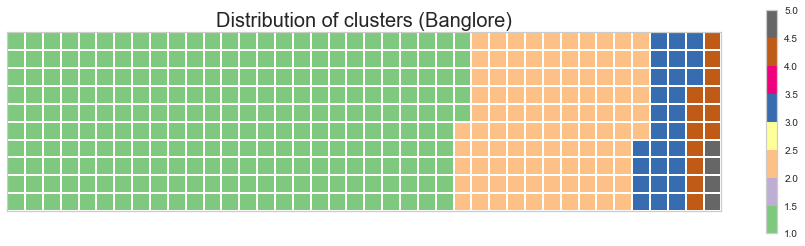

Cluster 1 has 237 records
Cluster 2 has 94 records
Cluster 3 has 25 records
Cluster 4 has 12 records
Cluster 5 has 4 records


In [349]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.Accent
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.title("Distribution of clusters (Banglore)",fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()
print("Cluster 1 has {} records".format(waffle.iloc[0,1]))
print("Cluster 2 has {} records".format(waffle.iloc[1,1]))
print("Cluster 3 has {} records".format(waffle.iloc[2,1]))
print("Cluster 4 has {} records".format(waffle.iloc[3,1]))
print("Cluster 5 has {} records".format(waffle.iloc[4,1]))
# print("Cluster 6 has {} records".format(waffle.iloc[5,1]))
# print("Cluster 7 has {} records".format(waffle.iloc[6,1]))

_**Location of clusters in map of Mumbai**_

In [315]:
latitude = 19.0760
longitude = 72.8777
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.076, 72.8777.


In [316]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow_r(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], 
                                  mumbai_merged['Neighbourhood'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.1).add_to(map_clusters)
       
map_clusters

_Now that we can see different clusters of location in Mumbai. Let's check the most common venues_

In [317]:
cluster_common = mumbai_merged.iloc[:,8:]
unique = []
for i in cluster_common.columns:
    unique.append(cluster_common[i].values.tolist())

In [318]:
cluster_lsi = list(itertools.chain.from_iterable(unique))

In [319]:
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is imported!')

Wordcloud is imported!


In [320]:
stopwords = set(STOPWORDS)

In [321]:
cluster = WordCloud(background_color='white',
    max_words=500,
    stopwords=stopwords)

In [322]:
cluster.generate(" ".join(cluster_lsi))

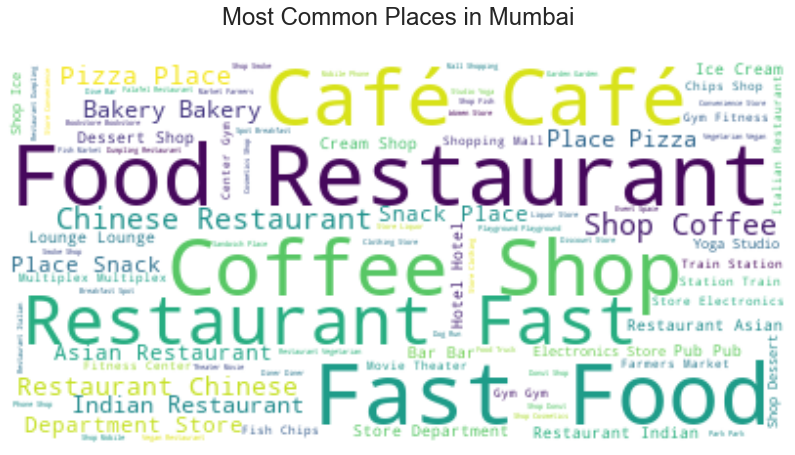

In [323]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(cluster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Places in Mumbai\n',fontsize=24)
plt.show()

In [324]:
px.bar(mumbai_merged['1st Most Common Venue'].sample(100),color=mumbai_merged['Cluster Labels'].sample(100),labels={
    'value':'Venues','color':'Clusters'},
       title='Venues in different clusters')

In [325]:
px.scatter(mumbai_merged['Price'],mumbai_merged['Cluster Labels'],color=mumbai_merged['Cluster Labels'],labels={
                     "index": "Price",
                     "x": "Clusters",
                     "color": "Clusters"}
       ,title='Property Rates in different clusters')

_**Location of clusters in map of Banglore**_

In [326]:
latitude =12.9716
longitude = 77.5946
print('The geograpical coordinate of Banglore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Banglore are 12.9716, 77.5946.


In [327]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(banglore_merged['Latitude'], banglore_merged['Longitude'], 
                                  banglore_merged['Neighbourhood'], banglore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.1).add_to(map_clusters)
       
map_clusters

_Now that we can see different clusters of location in Banglore. Let's check the most common venues_

In [328]:
cluster_common = banglore_merged.iloc[:,8:]
unique = []
for i in cluster_common.columns:
    unique.append(cluster_common[i].values.tolist())

In [329]:
cluster_lsi = list(itertools.chain.from_iterable(unique))

In [330]:
stopwords = set(STOPWORDS)

In [331]:
stopwords.add('Drink')
stopwords.add('Food')
stopwords.add('Flower Shop')

In [332]:
cluster = WordCloud(background_color='white',
    max_words=1000,
    stopwords=stopwords)

In [333]:
cluster.generate(" ".join(cluster_lsi))

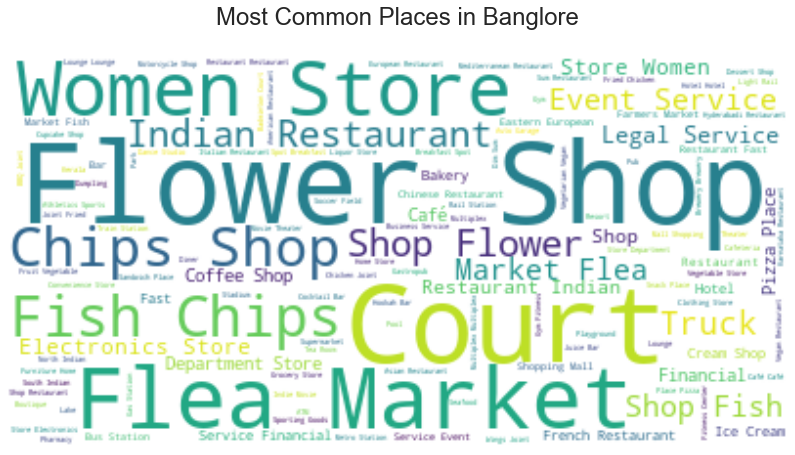

In [334]:
# display the cloud

fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(cluster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Places in Banglore\n',fontsize=24)
plt.show()

In [335]:
px.bar(banglore_merged['1st Most Common Venue'].sample(100),color=banglore_merged['Cluster Labels'].sample(100),labels={
    'value':'Venues','color':'Clusters'},
       title='Venues in different clusters')

In [336]:
px.scatter(banglore_merged['Price'],banglore_merged['Cluster Labels'],color=banglore_merged['Cluster Labels'],labels={
                     "index": "Price",
                     "x": "Clusters",
                     "color": "Clusters"}
       ,title='Property Rates in different clusters')

__Conclusion__

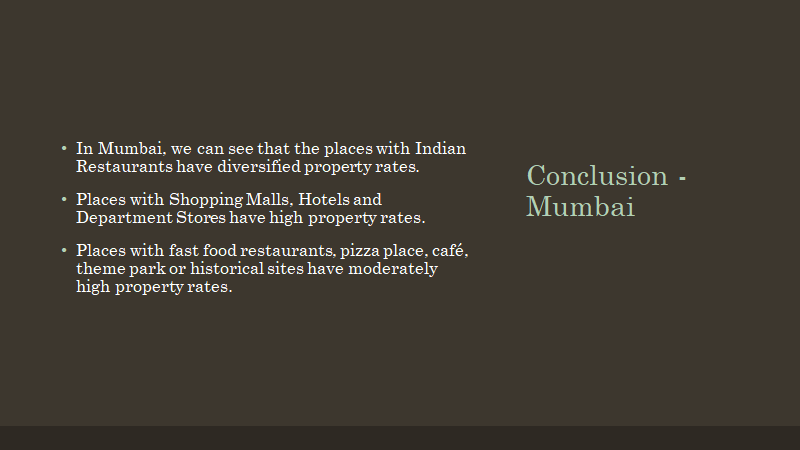


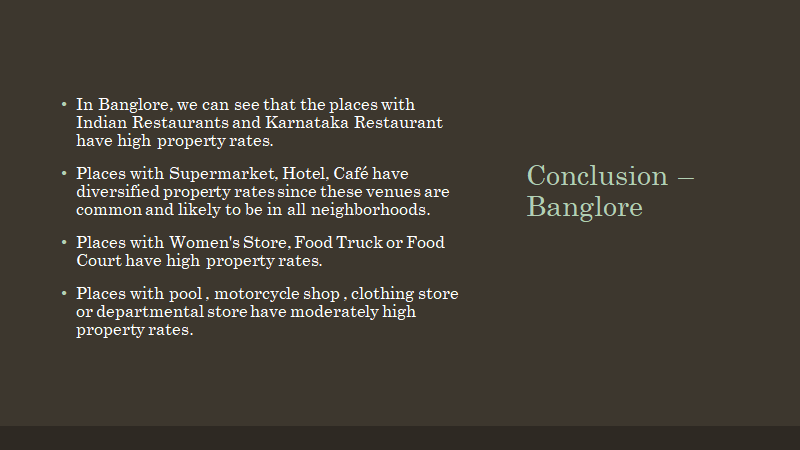